In [81]:
import time
import serial
import numpy as np

# Configuration
shacker_port = "/dev/ttyUSB0"    # Shacker's serial port
teensy_port = "/dev/ttyACM0"     # Teensy's serial port
baud_rate_shacker = 115200       # Baud rate for both devices
baud_rate_teensy = 2000000       # Baud rate for both devices
scale_factor = 16384.0           # Scale factor for raw data to g conversion

sampling_duration = 10    
frequency = 80.7

ser = serial.Serial(shacker_port, baud_rate_shacker, timeout=2)
print(f"Connected to Shacker on {shacker_port}")
time.sleep(3)
ser.write((str(frequency) + '\n').encode())
ser.close()

ser = serial.Serial(teensy_port, baud_rate_teensy, timeout=2)
print(f"Connected to Teensy on {teensy_port}")

timestamps = []
accel_x = []
accel_y = []
accel_z = []

start_time = time.time()

while time.time() - start_time < sampling_duration:
            
    line = ser.readline().decode('utf-8').strip()
    if line:
        try:
            # Parse raw data (X, Y, Z) from Teensy
            x, y, z = map(int, line.split(","))
            accel_x.append(x / scale_factor)
            accel_y.append(y / scale_factor)
            accel_z.append(z / scale_factor)
            timestamps.append(time.time() - start_time)
        except ValueError:
            print(f"Invalid line: {line}")

print("Data collection complete.")
data = np.column_stack((timestamps, accel_x, accel_y, accel_z))
np.savetxt("shacker_data.csv", data, delimiter=",", header="Time,X,Y,Z", comments="")
print("Data saved to shacker_data.csv")

ser = serial.Serial(shacker_port, baud_rate_shacker, timeout=2)
time.sleep(3)
ser.write((str(0) + "\n").encode())
ser.close()


Connected to Shacker on /dev/ttyUSB0
Connected to Teensy on /dev/ttyACM0
Invalid line: 324-14576,23892,-44
Data collection complete.
Data saved to shacker_data.csv


Top 5 Dominant Peaks (Frequency, Amplitude):
Frequency: 80.71 Hz, Amplitude: 1160.48
Frequency: 12.60 Hz, Amplitude: 159.48
Frequency: 14.00 Hz, Amplitude: 157.03
Frequency: 12.20 Hz, Amplitude: 127.53
Frequency: 15.60 Hz, Amplitude: 127.17


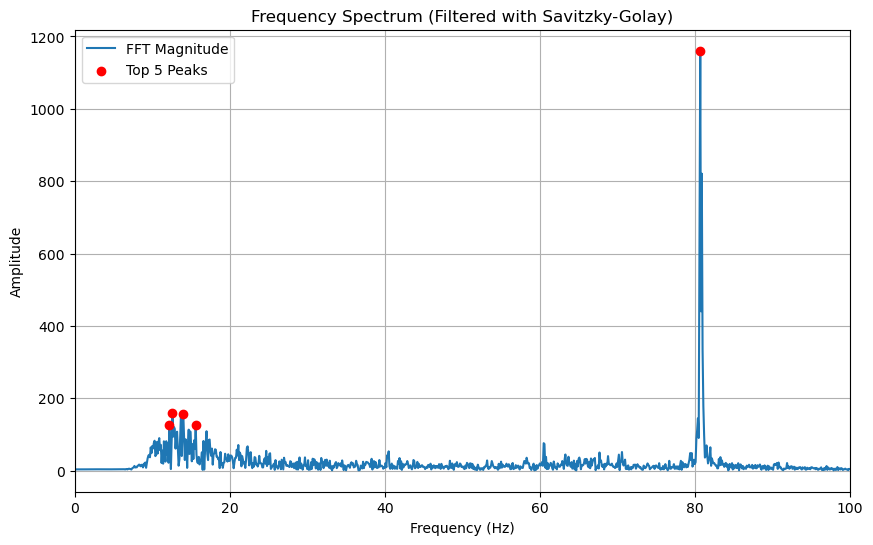

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter

# Load data from CSV file
data = np.loadtxt("shacker_data.csv", delimiter=",", skiprows=1)  # Replace with your CSV file name
timestamps = data[:, 0]  # First column: Timestamps
accel_x = data[:, 1]     # Second column: X-axis acceleration

# Define maximum frequency for peak detection
min_frequency = 10        # Hz
max_frequency = 100      # Hz
min_peak_distance = 0.5   # Minimum frequency separation in Hz

freq_plot_span = [0, 100]

# Calculate sampling rate (Fs) from timestamps
sampling_interval = np.mean(np.diff(timestamps))
Fs = 1 / sampling_interval  # Sampling frequency in Hz

# Band-pass filter
def band_pass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data)

# Apply band-pass filter (example: 5-150 Hz)
filtered_accel_x = band_pass_filter(accel_x, lowcut=min_frequency, highcut=max_frequency, fs=Fs, order=4)

# Apply Savitzky-Golay filter for smoothing
# Window length must be odd and less than the length of the data
savgol_filtered_accel_x = savgol_filter(filtered_accel_x, window_length=101, polyorder=4)

# Perform FFT on Savitzky-Golay filtered data
N = len(savgol_filtered_accel_x)
fft_values = fft(savgol_filtered_accel_x)
fft_magnitudes = np.abs(fft_values[:N // 2])
freqs = np.fft.fftfreq(N, d=sampling_interval)[:N // 2]

# Find peaks in the limited frequency range
min_bin_distance = int(min_peak_distance / (Fs / N))  # Convert to bins

peak_indices, _ = find_peaks(
    fft_magnitudes, 
    height=np.max(fft_magnitudes) * 0.1, 
    distance=min_bin_distance
)
peak_frequencies = freqs[peak_indices]
peak_magnitudes = fft_magnitudes[peak_indices]

# Sort peaks by magnitude and limit to top 5
sorted_indices = np.argsort(peak_magnitudes)[::-1]
top_n = 5  # Limit to top 5 peaks
peak_frequencies = peak_frequencies[sorted_indices][:top_n]
peak_magnitudes = peak_magnitudes[sorted_indices][:top_n]

# Output the top 5 peaks
print("Top 5 Dominant Peaks (Frequency, Amplitude):")
for freq, mag in zip(peak_frequencies, peak_magnitudes):
    print(f"Frequency: {freq:.2f} Hz, Amplitude: {mag:.2f}")

# Plot the frequency spectrum with top 5 peaks highlighted
plt.figure(figsize=(10, 6))
plt.plot(freqs, fft_magnitudes, label="FFT Magnitude")
plt.scatter(peak_frequencies, peak_magnitudes, color="red", label="Top 5 Peaks", zorder=5)
plt.xlim(freq_plot_span) 
plt.title("Frequency Spectrum (Filtered with Savitzky-Golay)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()